# Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

tick_major = 6
tick_minor = 4
plt.rcParams["xtick.major.size"] = tick_major
plt.rcParams["xtick.minor.size"] = tick_minor
plt.rcParams["ytick.major.size"] = tick_major
plt.rcParams["ytick.minor.size"] = tick_minor

font_small = 12
font_medium = 13
font_large = 14
plt.rc('font', size=font_small)          # controls default text sizes
plt.rc('axes', titlesize=font_medium)    # fontsize of the axes title
plt.rc('axes', labelsize=font_medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_small)    # legend fontsize
plt.rc('figure', titlesize=font_large)   # fontsize of the figure title

import matplotlib.colors as clr

# Model Controls

## Loading the Model

In [ ]:
from neuron import h
h.load_file("runModel.hoc")

	1 
	1 
Setting temperature to 34.000000 C
Setting simulation time step to 0.100000 ms
	1 
	1 


## Initialize Model Params

In [ ]:
def init_settings(nav12=1,
                  nav16=1,
                  dend_nav12=1, 
                  soma_nav12=1, 
                  ais_nav12=1, 
                  dend_nav16=1, 
                  soma_nav16=1,
                  ais_nav16=1, 
                  axon_Kp=1,
                  axon_Kt =1,
                  axon_K=1,
                  soma_K=1,
                  dend_K=1,
                  gpas_all=1):
    
    # create default model parameters to avoid loading the model
    
    h.dend_na12 = 0.026145/2 
    h.dend_na16 = h.dend_na12 
    h.dend_k = 0.004226 * soma_K


    h.soma_na12 = 0.983955/10 
    h.soma_na16 = h.soma_na12 
    h.soma_K = 0.303472 * soma_K

    h.ais_na16 = 4 
    h.ais_na12 = 4 
    h.ais_ca = 0.000990
    h.ais_KCa = 0.007104

    h.node_na = 2

    h.axon_KP = 0.973538 * axon_Kp
    h.axon_KT = 0.089259 * axon_Kt
    h.axon_K = 1.021945 * axon_K

    h.cell.axon[0].gCa_LVAstbar_Ca_LVAst = 0.001376286159287454
    
    #h.soma_na12 = h.soma_na12/2
    h.naked_axon_na = h.soma_na16/5
    h.navshift = -10
    h.myelin_na = h.naked_axon_na
    h.myelin_K = 0.303472
    h.myelin_scale = 10
    h.gpas_all = 3e-5 * gpas_all
    h.cm_all = 1
    
    
    h.dend_na12 = h.dend_na12 * nav12 * dend_nav12
    h.soma_na12 = h.soma_na12 * nav12 * soma_nav12
    h.ais_na12 = h.ais_na12 * nav12 * ais_nav12
    
    h.dend_na16 = h.dend_na16 * nav16 * dend_nav16
    h.soma_na16 = h.soma_na16 * nav16 * soma_nav16
    h.ais_na16 = h.ais_na16 * nav16 * ais_nav16
    
    
    
    
    h.working()

## Initialize Stimulation Params

In [ ]:
def init_stim(sweep_len = 800, stim_start = 100, stim_dur = 500, amp = 0.5, dt = 0.01):
    # updates the stimulation params used by the model
    # time values are in ms
    # amp values are in nA
    
    h("st.del = " + str(stim_start))
    h("st.dur = " + str(stim_dur))
    h("st.amp = " + str(amp))
    h.tstop = sweep_len
    h.dt = dt

## Run the model

In [ ]:
def run_model(start_Vm = -72):

    h.finitialize(start_Vm)
    timesteps = int(h.tstop/h.dt)
    
    Vm = np.zeros(timesteps)
    I = {}
    I['Na'] = np.zeros(timesteps)
    I['Ca'] = np.zeros(timesteps)
    I['K'] = np.zeros(timesteps)
    t = np.zeros(timesteps)
    
    for i in range(timesteps):
        Vm[i] = h.cell.soma[0].v
        I['Na'][i] = h.cell.soma[0](0.5).ina
        I['Ca'][i] = h.cell.soma[0](0.5).ica
        I['K'][i] = h.cell.soma[0](0.5).ik
        t[i] = i*h.dt / 1000
        h.fadvance()
        
    return Vm, I, t

## AP analysis code

In [72]:
def detect_spikes(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0002, properties=True):
    '''
    Method for idenifying spikes based on rates of change in the membrane potential
    INPUTS:
    Vm: array-like - membrane potential (mV)
    time: array-like - time corresponding to Vm (sec)
    dVdt_thresh: float - Threshold for determining spike initiation (V/s)
    min_spike_len: float - Minimum length of time dVdt must be above dVdt_thresh to be considered a spike (sec)
    properties: Bool - If true, returns spike_times and spike_properties. Otherwise returns only spike_properties

    Output:
    array of spike times

    Identification of spike start times:
    dVdt is first quanitified from Vm and time
    Continuous tretches (runs) of dVdt above dVdt_thresh are identified, and then esured to last longer than min_spike_len

    Spike Property measurement:
    spike_end is determined by finding the second zero crossing of dVdt after spike dVdt_threshold
    First zero crossing is AP peak, second should be end of repolarization phase
    Persistent zero crossing (must stay above zero for 3 continous points) is used to make sure that noise in slowly repolarizing spikes doesn't trigger spike end
    '''
    if len(Vm) != len(time):
        raise Exception("Vm and time must be the same length")

    #determine stretches where dVdt exceeds dVdt_thresh
    dVdt = np.gradient(Vm,time)/1e3
    runs = group_consecutives(np.argwhere((dVdt>=dVdt_thresh)).flatten())

    #If runs are longer than min_spike_len count as a spike
    dt = time[1]-time[0] #sample rate
    min_run_len = np.ceil(min_spike_len/dt)
    spike_times = []
    for run in runs:
        if len(run) > min_run_len:
            spike_times.append(time[run[0]])
    spike_times = np.asarray(spike_times)

    if not properties: #just return spike_times
        return spike_times

    #get spike properties
    spike_properties=[]
    for spike_time in spike_times:
        #find index of spike_time in time
        spike_start_idx = np.argwhere(spike_time == time)[0][0]

        #find zero crossings of dVdt after spike dVdt_threshold
        zero_crosses = find_zero_crossing(dVdt[spike_start_idx:-1])
        #make sure zero cross is persistent to account for noise
        if len(zero_crosses) > 1:
            spike_end_idx = spike_start_idx\
                            + zero_crosses[np.argwhere(np.diff(zero_crosses)>3)[0] + 1][0]
        else: #Vm ends before spike can repolarize, therefore assigned Vm[-1] as spike end
            spike_end_idx = len(Vm)-1

        spike_Vm = Vm[spike_start_idx:spike_end_idx]
        spike_time = time[spike_start_idx:spike_end_idx] - time[spike_start_idx]
        spike_dVdt = dVdt[spike_start_idx:spike_end_idx]
        spike = {}
        spike['start_idx'] = spike_start_idx
        spike['start_time'] = time[spike_start_idx]
        spike['end_idx'] = spike_end_idx
        spike['end_time'] = time[spike_end_idx]
        spike['Vm'] = spike_Vm
        spike['time'] = spike_time
        spike['thresh'] = spike_Vm[0]
        spike['peak_Vm'] = spike_Vm.max()
        spike['height'] = np.max(spike_Vm)-spike_Vm[0]
        spike['AHP'] = spike_Vm[0]-spike_Vm[-1]
        spike['peak_dVdt'] = spike_dVdt.max()
        spike['min_dVdt'] = spike_dVdt.min()
        try:
            half_pnts = find_zero_crossing(spike_Vm - (spike_Vm[0]+(np.max(spike_Vm)-spike_Vm[0])/2))
            spike['half_width'] = (half_pnts[1]-half_pnts[0])*dt*1000
        except: #For slowly repolarizing spikes this can sometimes fail
            spike['half_width'] = np.nan

        spike_properties.append(spike)
    return spike_times,spike_properties

def detect_spike_times(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0002):
    '''
    Wrapper of detect_spikes to only get spike times
    '''
    return detect_spikes(Vm, time,
                          dVdt_thresh = dVdt_thresh,
                          min_spike_len = min_spike_len,
                          properties=False)

def detect_spike_properties(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0001):
    '''
    Wrapper of detect_spikes to only get spike properties
    '''
    return detect_spikes(Vm, time,
                          dVdt_thresh = dVdt_thresh,
                          min_spike_len = min_spike_len,
                          properties=True)[1]

def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

def find_zero_crossing(x):
    '''
    returns array of indicies before a zero crossing occur
    If your input array starts and stops with zeros, it will find a zero crossing at the beginning, but not at the end
    '''
    zero_crossings = np.where(np.diff(np.signbit(x)))[0]
    return zero_crossings

# Model NaV distributions

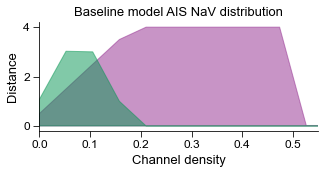

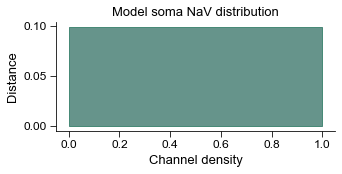

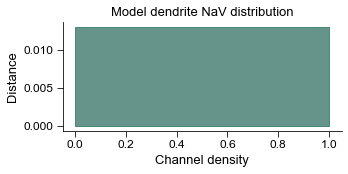

In [73]:

init_settings()

NaV12 = []
NaV16 = []
distance = []
nseg = h.cell.axon[0].nseg

# distance.append(-.4)
# distance.append(-.2)
# NaV12.append(h.dend_na12)
# NaV16.append(h.dend_na16)
# NaV12.append(h.dend_na12)
# NaV16.append(h.dend_na16)

# distance.append(-.2)
# distance.append(0)
# NaV12.append(h.soma_na12)
# NaV16.append(h.soma_na16)
# NaV12.append(h.soma_na12)
# NaV16.append(h.soma_na16)

for i in range(nseg):
    x = i/nseg
    distance.append(x)
    NaV12.append(h.cell.axon[0](x).gbar_na12 + h.cell.axon[0](x).gbar_na12mut)
    NaV16.append(h.cell.axon[0](x).gbar_na16)





NaV12 = np.asarray(NaV12)
NaV16 = np.asarray(NaV16)   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,2), sharex=False, sharey=False)
ax.set_title('Baseline model AIS NaV distribution')

ax.set_ylabel("Distance")
ax.set_xlabel("Channel density")

ax.fill_between(distance, NaV16, label = 'NaV16', color = '#922A8E', alpha=0.5)
ax.fill_between(distance, NaV12, label = 'NaV12', color = '#059552', alpha=0.5)

ax.set_xlim(0, 0.55)



# plt.savefig('Model_ais_distribution.pdf')
# ax = plot_AIS_NaV_distribution(ax)
plt.show()





fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,2), sharex=False, sharey=False)
ax.set_title('Model soma NaV distribution')

ax.set_ylabel("Distance")
ax.set_xlabel("Channel density")

ax.fill_between( [0, 1], [h.soma_na16, h.soma_na16], label = 'NaV16', color = '#922A8E', alpha=0.5)
ax.fill_between([0, 1], [h.soma_na12, h.soma_na12], label = 'NaV12', color = '#059552', alpha=0.5)

# plt.savefig('Model_soma_distribution.pdf')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,2), sharex=False, sharey=False)
ax.set_title('Model dendrite NaV distribution')

ax.set_ylabel("Distance")
ax.set_xlabel("Channel density")

ax.fill_between( [0, 1], [h.dend_na16, h.dend_na16], label = 'NaV16', color = '#922A8E', alpha=0.5)
ax.fill_between([0, 1], [h.dend_na12, h.dend_na12], label = 'NaV12', color = '#059552', alpha=0.5)

# plt.savefig('Model_dend_distribution.pdf')
plt.show()

# AP Waveform

In [74]:
def AP1_phase_plane(ax1, ax2, label):
    ax1.set_xlabel('Time (sec)')
    ax1.set_ylabel('Vm (mV)')

    ax2.set_xlabel('Vm (mV)')
    ax2.set_ylabel('dVdt (V/s)')
    
    Vm, I, t = run_model()
    
    spikes = detect_spike_properties(Vm, t)
    
    Vm = spikes[0]['Vm']
    t = np.arange(len(Vm))*h.dt
    dvdt = np.gradient(Vm)/h.dt
    
    ax1.plot(t[:int(2/h.dt)], Vm[:int(2/h.dt)], linewidth = 1, label = label)
    ax1.set_ylim(-55,40)
    ax1.set_xlim(0,2)
    ax2.plot(Vm, dvdt, linewidth = 1)
    ax2.set_ylim(-150,550)
    ax2.set_xlim(-55,40)
    return spikes[0]['peak_dVdt'], spikes[0]['thresh']

def AP1_phase_plane_comparison_axes(percents, cmap):
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharex=False, sharey=False)
    ax1.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
    ax2.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
    
    ax1.set_title = 'AP Waveform'
    ax1.set_ylabel('Vm (mV)')
    ax1.set_xlabel('Time (ms)')
    
    ax2.set_title = 'Phase Plane'
    ax2.set_ylabel('dVdt (V/s)')
    ax2.set_xlabel('Vm (mV)')

    ax3.set_title = 'Peak dVdt'
    ax3.set_ylabel('dVdt (V/s)')
    ax3.set_xlabel('Conductance fraction')
    ax3.set_ylim(0,550)
    
    ax4.set_title = 'Threshold'
    ax4.set_ylabel('Threshold (mV)')
    ax4.set_xlabel('Conductance fraction')
    ax4.set_ylim(-55,-50)
    
    return fig, ax1, ax2, ax3, ax4

def init_stim_for_phase_plane(amp=0.5):
    sweep_len = 50
    stim_dur = 25
    stim_start = 25
    amp = amp
    dt = 0.01

    init_stim(sweep_len=sweep_len, 
              stim_start=stim_start,
              stim_dur=stim_dur,
              amp=amp,
              dt=dt)

def highResPoints(x,y,factor=10):
    '''
    Take points listed in two vectors and return them at a higher
    resultion. Create at least factor*len(x) new points that include the
    original points and those spaced in between.

    Returns new x and y arrays as a tuple (x,y).
    '''

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1]
        dy = y[i]-y[i-1]
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    dr = rtot[-1]/(NPOINTS*RESFACT-1)
    xmod=[x[0]]
    ymod=[y[0]]
    rPos = 0 # current point on walk along data
    rcount = 1 
    while rPos < r.sum():
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        dpos = rPos-rtot[rcount] 
        theta = np.arctan2((x2-x1),(y2-y1))
        rx = np.sin(theta)*dpos+x1
        ry = np.cos(theta)*dpos+y1
        xmod.append(rx)
        ymod.append(ry)
        rPos+=dr
        while rPos > rtot[rcount+1]:
            rPos = rtot[rcount+1]
            rcount+=1
            if rcount>rtot[-1]:
                break

    return xmod,ymod

## Reducing NaV12

### Reducing NaV12 – All Compartments

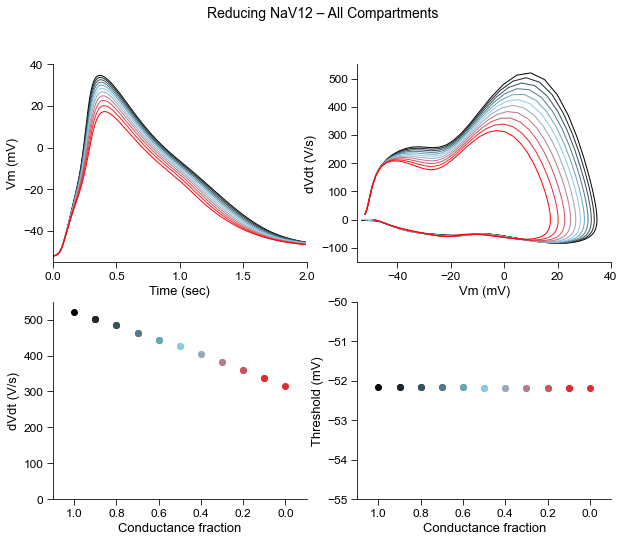

In [75]:
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'red')], N=256)

### PLOTS ###
init_stim_for_phase_plane()
percents = np.arange(1,-0.1,-.1)
fig, ax1, ax2, ax3, ax4 = AP1_phase_plane_comparison_axes(percents, cmap)
fig.suptitle('Reducing NaV12 – All Compartments')
dvdt = []
thresh = []
for i, p in enumerate(percents):
    init_settings(nav12 = p) ### set conductance here
    dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
    dvdt.append(dvdt_temp)
    thresh.append(thresh_temp)

    

ax3.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)-1):
    ax3.scatter(percents[i:i+2],dvdt[i:i+2])
ax3.set_xlim(1.1,-0.1)    

ax4.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)-1):
    ax4.scatter(percents[i:i+2],thresh[i:i+2])
ax4.set_xlim(1.1,-0.1)
    
# plt.savefig('Phase-plane - Reducing NaV12 – All Compartments.pdf')
plt.show()

## NaV16 compensation in Nav12 hom

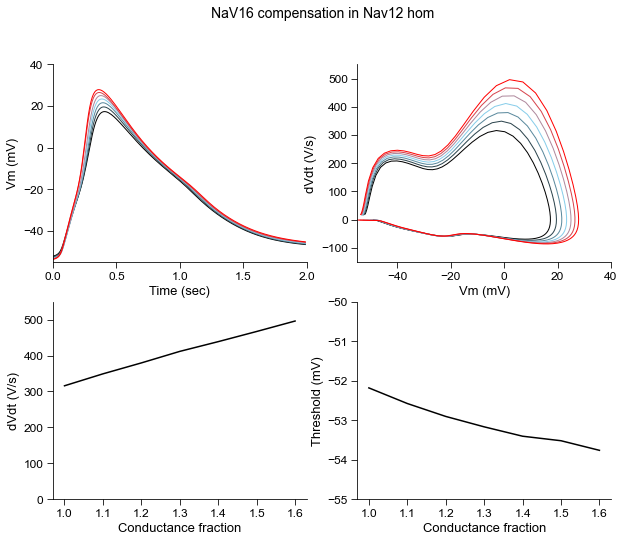

In [79]:
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'red')], N=256)

### PLOTS ###
init_stim_for_phase_plane()
percents = np.arange(1,1.6,0.1)
fig, ax1, ax2, ax3, ax4 = AP1_phase_plane_comparison_axes(percents, cmap)
fig.suptitle('NaV16 compensation in Nav12 hom')
dvdt = []
thresh = []
for i, p in enumerate(percents):
    init_settings(nav12 = 0, nav16 = p) ### set conductance here
    dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
    dvdt.append(dvdt_temp)
    thresh.append(thresh_temp)
ax3.plot(percents, dvdt, color = 'k')
ax4.plot(percents, thresh, color = 'k')
# plt.savefig('Phase-plane - NaV16 compensation in Nav12 hom')
plt.show()

## NaV16 AIS compensation in Nav12 hom

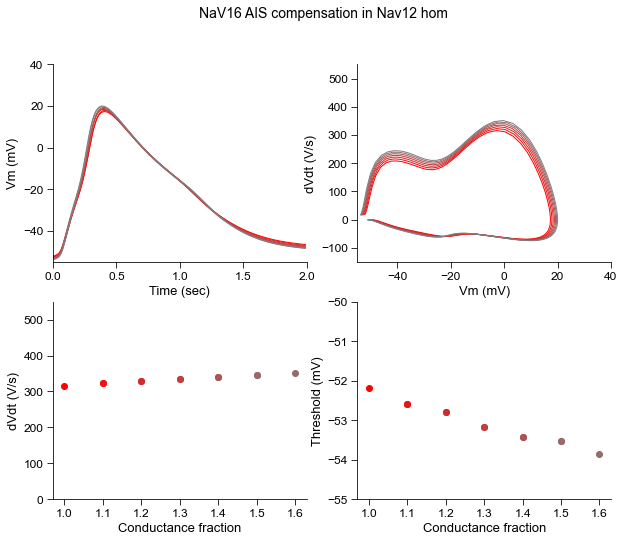

In [80]:
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'red'),
                                          (1,    'grey')], N=256)

### PLOTS ###
init_stim_for_phase_plane()
percents = np.arange(1,1.6,0.1)
fig, ax1, ax2, ax3, ax4 = AP1_phase_plane_comparison_axes(percents, cmap)
fig.suptitle('NaV16 AIS compensation in Nav12 hom')
dvdt = []
thresh = []
for i, p in enumerate(percents):
    init_settings(nav12 = 0, ais_nav16 = p) ### set conductance here
    dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
    dvdt.append(dvdt_temp)
    thresh.append(thresh_temp)

ax3.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)-1):
    ax3.scatter(percents[i:i+2],dvdt[i:i+2])

ax4.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)-1):
    ax4.scatter(percents[i:i+2],thresh[i:i+2])
    
# plt.savefig('Phase-plane - NaV16 AIS compensation in Nav12 hom.pdf')
plt.show()

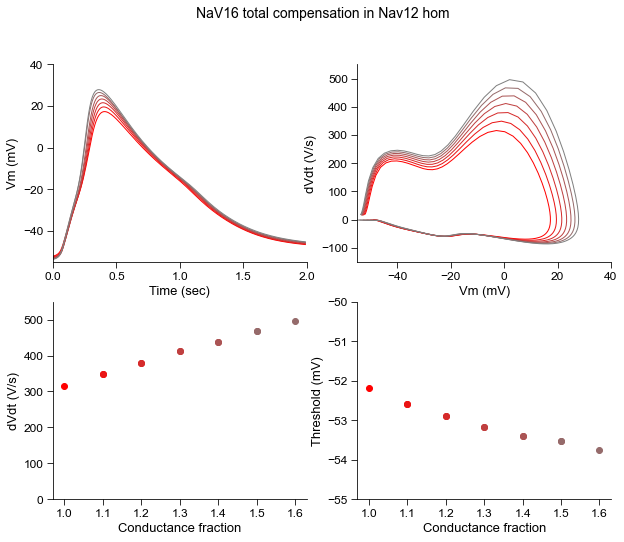

In [81]:
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'red'),
                                          (1,    'grey')], N=256)

### PLOTS ###
init_stim_for_phase_plane()
percents = np.arange(1,1.6,0.1)
fig, ax1, ax2, ax3, ax4 = AP1_phase_plane_comparison_axes(percents, cmap)
fig.suptitle('NaV16 total compensation in Nav12 hom')
dvdt = []
thresh = []
for i, p in enumerate(percents):
    init_settings(nav12 = 0, nav16 = p) ### set conductance here
    dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
    dvdt.append(dvdt_temp)
    thresh.append(thresh_temp)

ax3.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)-1):
    ax3.scatter(percents[i:i+2],dvdt[i:i+2])

ax4.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)-1):
    ax4.scatter(percents[i:i+2],thresh[i:i+2])
    
# plt.savefig('Phase-plane - NaV16 total compensation in Nav12 hom.pdf')
plt.show()

## Restoring Somatic NaV1.2 in NaV1.2 KO

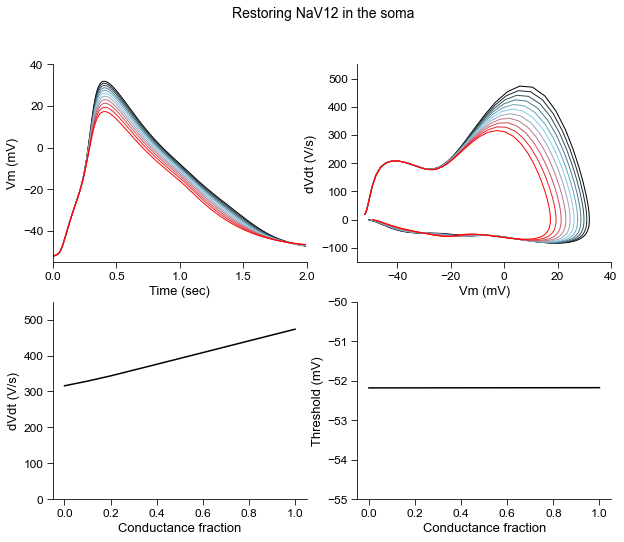

In [82]:
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'red')], N=256)

### PLOTS ###
init_stim_for_phase_plane()
percents = np.arange(1,-0.1,-.1)
fig, ax1, ax2, ax3, ax4 = AP1_phase_plane_comparison_axes(percents, cmap)
fig.suptitle('Restoring NaV12 in the soma')
dvdt = []
thresh = []
for i, p in enumerate(percents):
    init_settings(ais_nav12 = 0, soma_nav12 = p,dend_nav12 = 0) ### set conductance here
    dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
    dvdt.append(dvdt_temp)
    thresh.append(thresh_temp)
ax3.plot(percents, dvdt, color = 'k')
ax4.plot(percents, thresh, color = 'k')
# plt.show('Phase-plane - Restoring NaV12 in the soma')
plt.show()

## Reducing NaV16

#### Reducing NaV16 – All Compartments

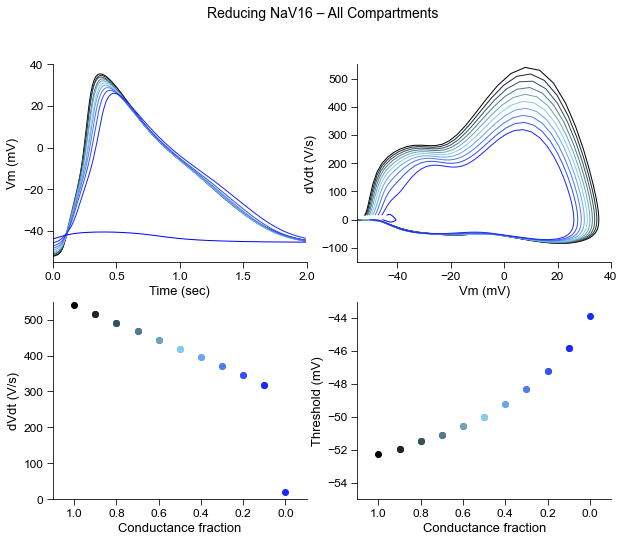

In [83]:
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'blue')], N=256)

### PLOTS ###
init_stim_for_phase_plane(amp=0.8)
percents = np.arange(1,-0.1,-.1)
fig, ax1, ax2, ax3, ax4 = AP1_phase_plane_comparison_axes(percents, cmap)
fig.suptitle('Reducing NaV16 – All Compartments')
dvdt = []
thresh = []
for i, p in enumerate(percents):
    init_settings(nav16 = p) ### set conductance here
    dvdt_temp, thresh_temp = AP1_phase_plane(ax1, ax2, label = '{}%'.format(int(p*100)))
    dvdt.append(dvdt_temp)
    thresh.append(thresh_temp)
ax3.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)-1):
    ax3.scatter(percents[i:i+2],dvdt[i:i+2])
ax3.set_xlim(1.1,-0.1)    

ax4.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
for i in range(len(percents)-1):
    ax4.scatter(percents[i:i+2],thresh[i:i+2])
ax4.set_xlim(1.1,-0.1)
ax4.set_ylim(-55,-43)
# plt.savefig('Phase-plane - Reducing NaV16 – All Compartments.pdf')
plt.show()

# FI Curves

## FI Curve support functions

In [88]:
def FI_curve(stims, stim_start = 50, stim_dur = 300, sweep_len = 350, dt = 0.1):
             
    f = []
    i = []
    for amp in stims:
        i.append(amp)
        init_stim(stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len, dt=dt, amp=amp)
        
        Vm, I, t = run_model()
        spike_times = detect_spike_times(Vm, t)
        f.append(len(spike_times))
    
    return f, i

def FI_curve_plot(stims, ax, label='', stim_start = 50, stim_dur = 300, sweep_len = 350, dt = 0.5):
    f, i = FI_curve(stims=stims, stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len, dt=dt)
    
    ax.set_ylim(0,12)
    ax.set_ylabel('Spikes per Epoch ({}ms)'.format(stim_dur))
    ax.set_xlabel('Injected Current (nA)')
    ax.plot(i, f, linewidth = 1, label=label) 


## Reducing NaV12

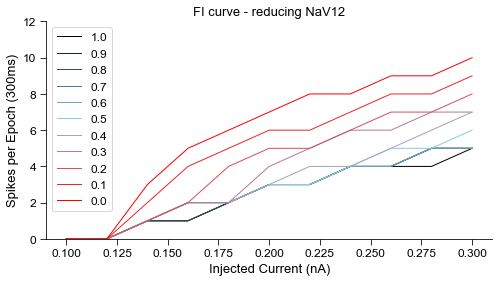

In [89]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(1,-0.1,-.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'red')], N=256)

ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

for p in percents:
    init_settings(nav12 = p)
    FI_curve_plot(stims, ax, label=str(np.round(p,2)), stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)
plt.legend()
title='FI curve - reducing NaV12'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Reducing NaV16

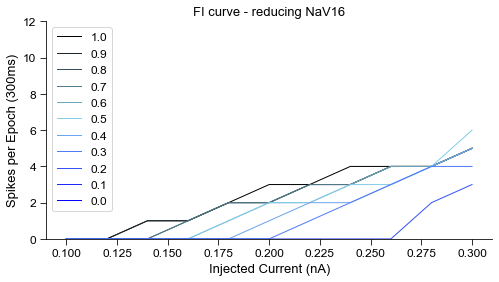

In [90]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(1,-0.1,-.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'blue')], N=256)

ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

for p in percents:
    init_settings(nav16 = p)
    FI_curve_plot(stims, ax, label=str(np.round(p,2)), stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)
plt.legend()
title='FI curve - reducing NaV16'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Increasing AIS_NaV16 in NaV12 Hom

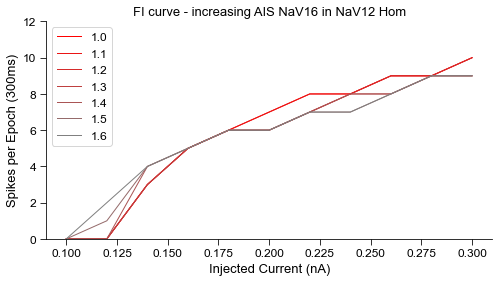

In [91]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(1,1.6,0.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'red'),
                                          (1,    'grey')], N=256)

ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

for p in percents:
    init_settings(nav12 = 0, ais_nav16 = p)
    FI_curve_plot(stims, ax, label=str(np.round(p,2)), stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)
plt.legend()    
title='FI curve - increasing AIS NaV16 in NaV12 Hom'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

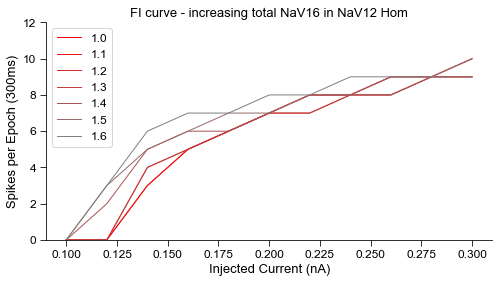

In [92]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(1,1.6,0.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'red'),
                                          (1,    'grey')], N=256)

ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

for p in percents:
    init_settings(nav12 = 0, nav16 = p)
    FI_curve_plot(stims, ax, label=str(np.round(p,2)), stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)
plt.legend()    
title='FI curve - increasing total NaV16 in NaV12 Hom'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Increasing AIS_NaV16 in WT

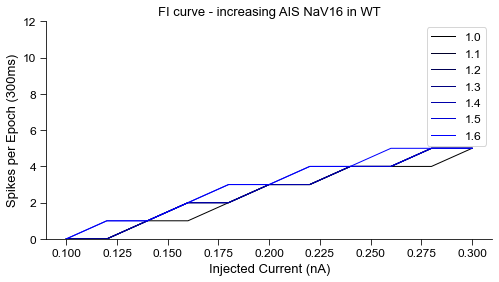

In [93]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(1,1.6,0.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'black'),
                                          (1,    'blue')], N=256)

ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

for p in percents:
    init_settings(ais_nav16 = p)
    FI_curve_plot(stims, ax, label=str(np.round(p,2)), stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)
plt.legend()    
title='FI curve - increasing AIS NaV16 in WT'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

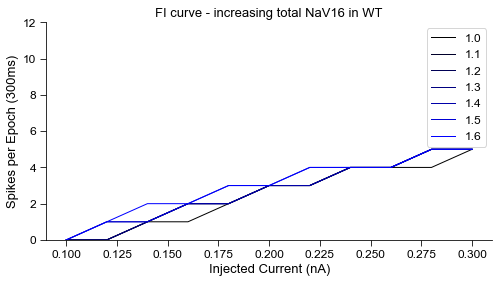

In [94]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(1,1.6,0.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'black'),
                                          (1,    'blue')], N=256)

ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

for p in percents:
    init_settings(nav16 = p)
    FI_curve_plot(stims, ax, label=str(np.round(p,2)), stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)
plt.legend()    
title='FI curve - increasing total NaV16 in WT'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Increasing Kp_axon in NaV12 Hom

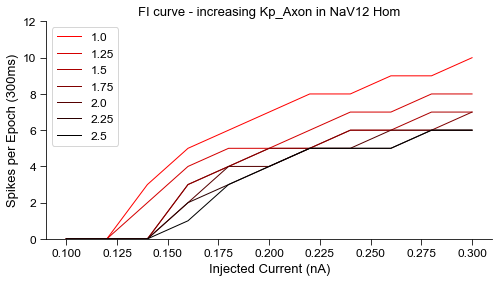

In [95]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(1,2.6,.25)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (1,    'red')], N=256)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)

ax.set_prop_cycle('color',cmap(np.linspace(1,0,len(percents))))

for p in percents:
    init_settings(nav12=0, axon_Kp = p)
    FI_curve_plot(stims, ax, label=p, stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)
ax.legend()
title='FI curve - increasing Kp_Axon in NaV12 Hom'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Reducing Kp_axon in WT

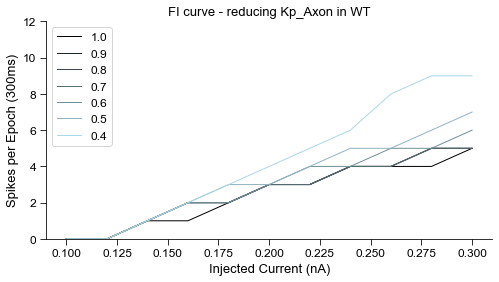

In [97]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(1,0.3,-.1)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (1,    'lightblue')], N=256)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)

ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

for p in percents:
    init_settings(axon_Kp = p)
    FI_curve_plot(stims, ax, label=str(np.round(p,2)), stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)
ax.legend()    
title='FI curve - reducing Kp_Axon in WT'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Increasing soma_nav12 in NaV12 Hom

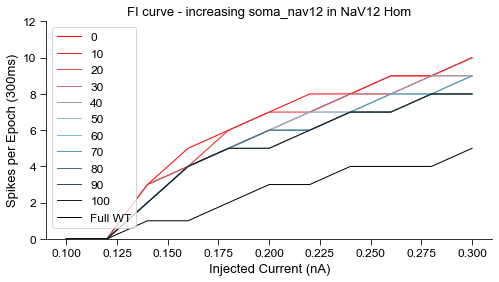

In [98]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(0,1.1,0.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)
ax.set_title('Increasing ais_nav12 in NaV12 Hom')
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'red')], N=256)

ax.set_prop_cycle('color',cmap(np.linspace(1,0,len(percents) + 1)))



for p in percents:
    init_settings(soma_nav12 = p, ais_nav12 = 0, dend_nav12 = 0)
    FI_curve_plot(stims, ax, label=str(int(p*100)), stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)

    

init_settings()
FI_curve_plot(stims, ax, label='Full WT', stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)

ax.legend()


title='FI curve - increasing soma_nav12 in NaV12 Hom'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Increasing ais_nav12 in NaV12 Hom


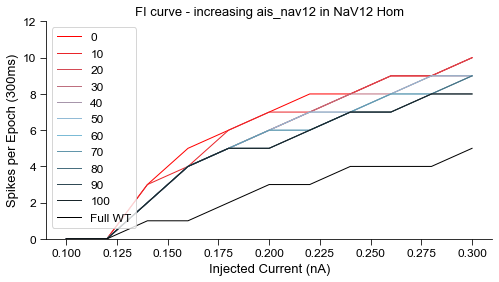

In [99]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(0,1.1,0.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)
ax.set_title('Increasing ais_nav12 in NaV12 Hom')
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'red')], N=256)

ax.set_prop_cycle('color',cmap(np.linspace(1,0,len(percents) + 1)))



for p in percents:
    init_settings(soma_nav12 = 0, ais_nav12 = p, dend_nav12 = 0)
    FI_curve_plot(stims, ax, label=str(int(p*100)), stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)    

init_settings()
FI_curve_plot(stims, ax, label='Full WT', stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)

ax.legend()
title='FI curve - increasing ais_nav12 in NaV12 Hom'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Increasing ais_ and soma_nav12 in Nav12 Hom

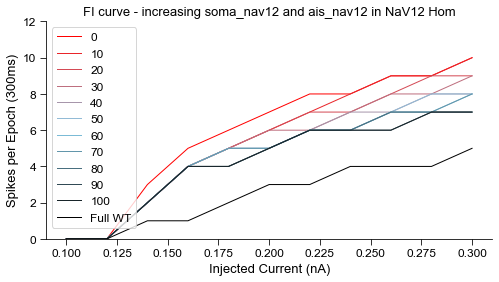

In [100]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(0,1.1,0.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)
ax.set_title('Increasing ais_nav12 in NaV12 Hom')
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'red')], N=256)

ax.set_prop_cycle('color',cmap(np.linspace(1,0,len(percents) + 1)))



for p in percents:
    init_settings(soma_nav12 = p, ais_nav12 = p, dend_nav12 = 0)
    FI_curve_plot(stims, ax, label=str(int(p*100)), stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)    

init_settings()
FI_curve_plot(stims, ax, label='Full WT', stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)

ax.legend()
title='FI curve - increasing soma_nav12 and ais_nav12 in NaV12 Hom'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Increasing dend_nav12 in Nav12 Hom

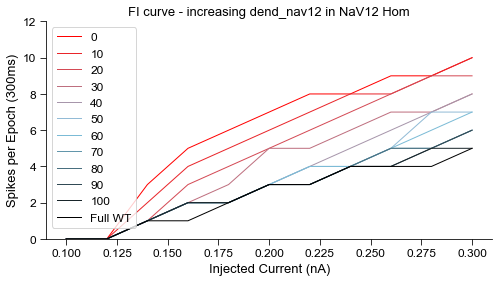

In [101]:
stims = np.arange(0.1,.31,.02)
percents = np.arange(0,1.1,0.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), sharex=False, sharey=False)
ax.set_title('Increasing dend_nav12 in NaV12 Hom')
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                         [(0,    'k'),
                                          (0.5, 'skyblue'),
                                          (1,    'red')], N=256)

ax.set_prop_cycle('color',cmap(np.linspace(1,0,len(percents) + 1)))



for p in percents:
    init_settings(soma_nav12 = 0, ais_nav12 = 0, dend_nav12 = p)
    FI_curve_plot(stims, ax, label=str(int(p*100)), stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)    

init_settings()
FI_curve_plot(stims, ax, label='Full WT', stim_start = 25, stim_dur = 300, sweep_len = 325, dt = .2)

ax.legend()
title='FI curve - increasing dend_nav12 in NaV12 Hom'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Example spikes

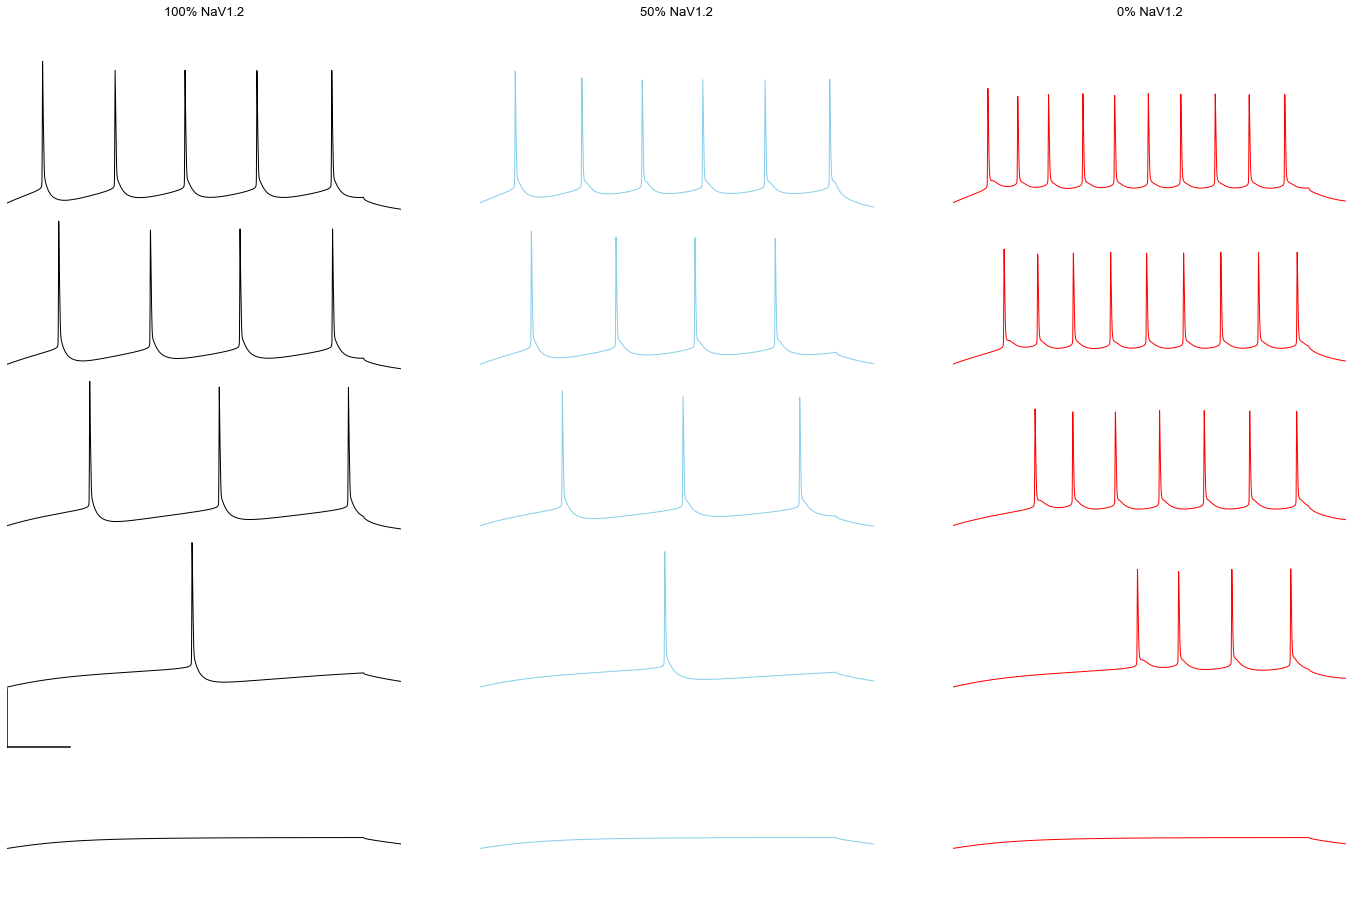

[0.1  0.15 0.2  0.25 0.3 ]


In [113]:
def FI_curve_spikes(stims, ax, title='', color='k', stim_start = 50, stim_dur = 300, sweep_len = 350, dt = 0.1):
    
    for i, amp in enumerate(stims):
        init_stim(stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len, dt=dt, amp=amp)
        Vm, I, t = run_model()
        ax.plot(t, Vm + 110 *i, linewidth=1, color=color)
        
    ax.set_title(title)
    ax.set_axis_off()
    
stim_start = 10
stim_dur = 300
sweep_len = 350
dt = 0.1
x_min = .025
x_max = 0.34

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(24, 16), sharex=False, sharey=True)

stims = np.arange(0.1, .31, .05)

init_settings()
FI_curve_spikes(stims, ax1, color='k', title='100% NaV1.2',stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len)
ax1.set_xlim(x_min, x_max)

init_settings(nav12=0.5)
FI_curve_spikes(stims, ax2, color='skyblue', title='50% NaV1.2',stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len)
ax2.set_xlim(x_min, x_max)

init_settings(nav12=0)
FI_curve_spikes(stims, ax3, color='red', title='0% NaV1.2',stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len)
ax3.set_xlim(x_min, x_max)

ax1.plot([x_min, x_min], [0, 40], color = 'k')
ax1.plot([x_min, x_min + .05], [0, 0], color = 'k')

# plt.savefig("{}.pdf".format('model_FI_curve_spiking'), transparent=True)

plt.show()
print(stims)

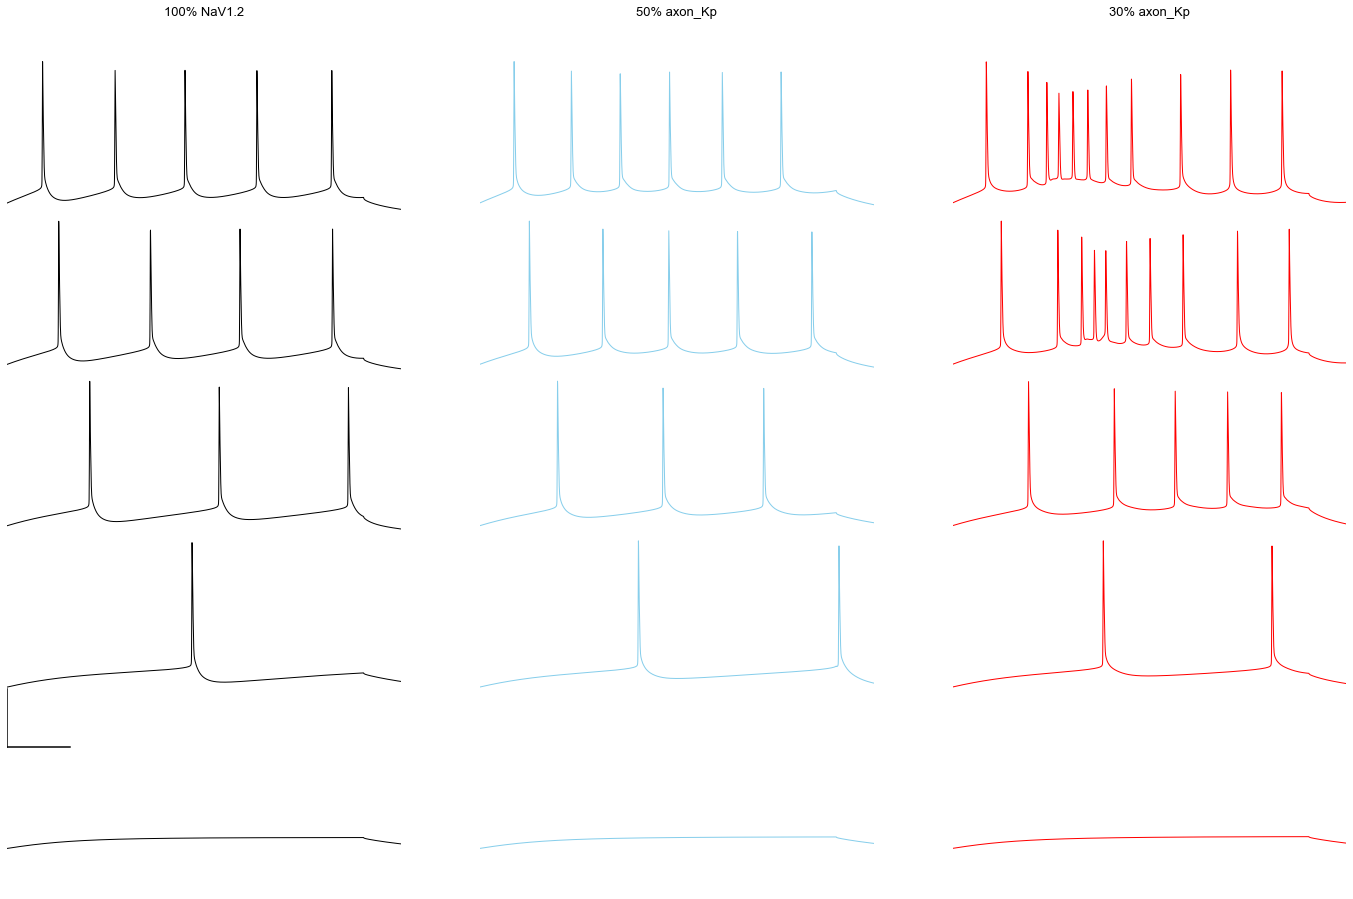

[0.1  0.15 0.2  0.25 0.3 ]


In [114]:
stim_start = 10
stim_dur = 300
sweep_len = 350
dt = 0.1
x_min = .025
x_max = 0.34

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(24, 16), sharex=False, sharey=True)

stims = np.arange(0.1, .31, .05)

init_settings()
FI_curve_spikes(stims, ax1, color='k', title='100% NaV1.2',stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len)
ax1.set_xlim(x_min, x_max)

init_settings(axon_Kp=0.5)
FI_curve_spikes(stims, ax2, color='skyblue', title='50% axon_Kp',stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len)
ax2.set_xlim(x_min, x_max)

init_settings(axon_Kp=.3)
FI_curve_spikes(stims, ax3, color='red', title='30% axon_Kp',stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len)
ax3.set_xlim(x_min, x_max)

ax1.plot([x_min, x_min], [0, 40], color = 'k')
ax1.plot([x_min, x_min + .05], [0, 0], color = 'k')

# plt.savefig("{}.pdf".format('model_FI_curve_spiking'), transparent=True)

plt.show()
print(stims)

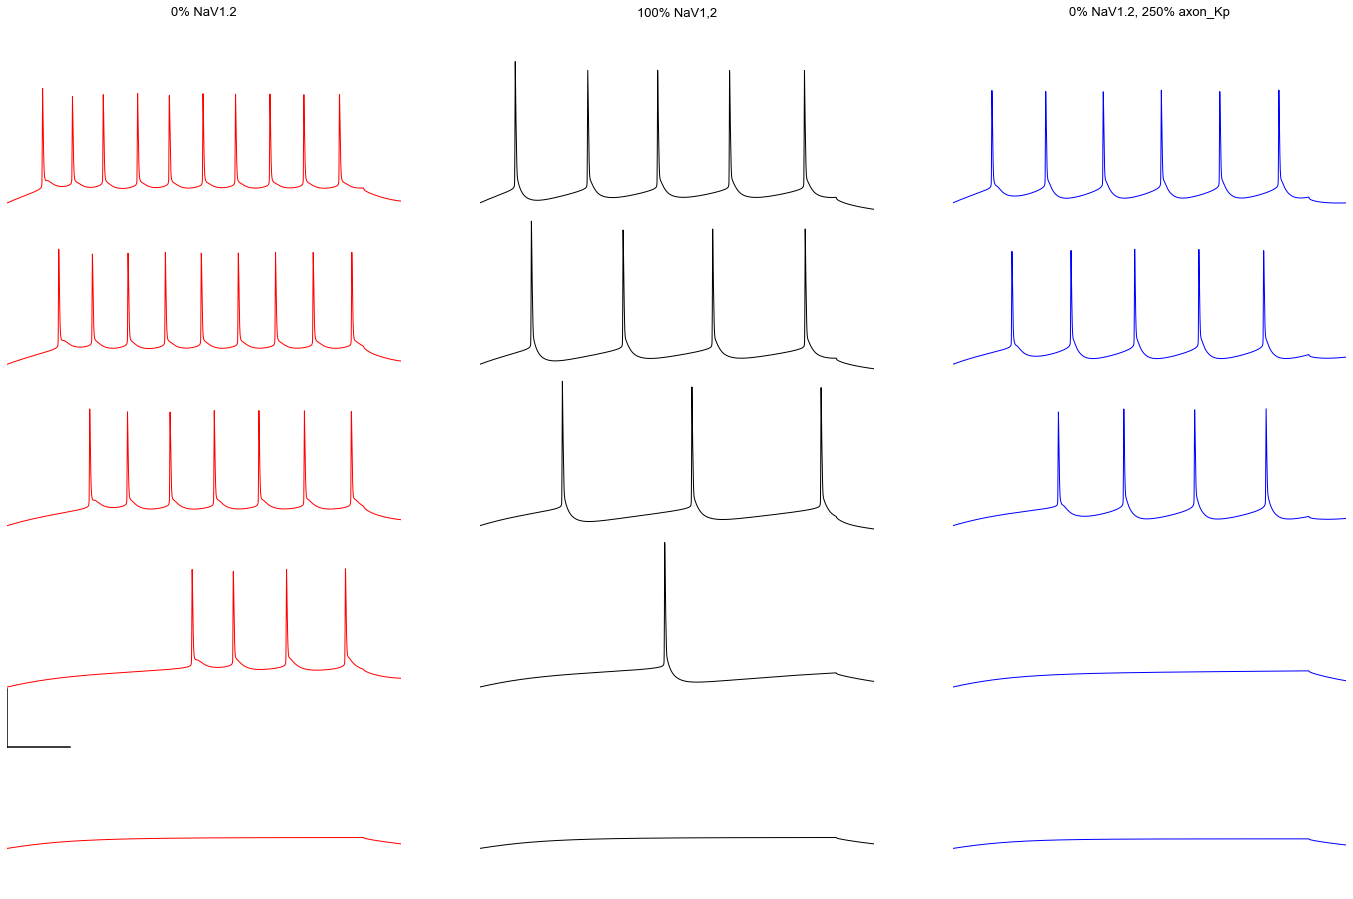

[0.1  0.15 0.2  0.25 0.3 ]


In [115]:
stim_start = 10
stim_dur = 300
sweep_len = 350
dt = 0.1
x_min = .025
x_max = 0.34

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(24, 16), sharex=False, sharey=True)

stims = np.arange(0.1, .31, .05)

init_settings(nav12=0)
FI_curve_spikes(stims, ax1, color='red', title='0% NaV1.2',stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len)
ax1.set_xlim(x_min, x_max)

init_settings()
FI_curve_spikes(stims, ax2, color='k', title='100% NaV1,2',stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len)
ax2.set_xlim(x_min, x_max)

init_settings(nav12=0, axon_Kp=2.5)
FI_curve_spikes(stims, ax3, color='blue', title='0% NaV1.2, 250% axon_Kp',stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len)
ax3.set_xlim(x_min, x_max)

ax1.plot([x_min, x_min], [0, 40], color = 'k')
ax1.plot([x_min, x_min + .05], [0, 0], color = 'k')

# plt.savefig("{}.pdf".format('model_FI_curve_spiking'), transparent=True)

plt.show()
print(stims)

# AHP

In [116]:
def ahp_plot_axes():


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), sharex=False, sharey=False)

    ax.set_ylabel('Vm (mV)')
    ax.set_ylabel('Time (sec)')
    ax.plot([0, 0], [-40,-20])
    ax.plot([0, 0.005], [-40,-40])

#     ax.axis('off')

    ax.set_ylim(-75,50)
    ax.set_xlim(0.035, 0.073)
    return fig, ax

sweep_len = 100
stim_dur = 50
stim_start = 25
amp = 0.6
dt = 0.1
init_stim(sweep_len=sweep_len, 
          stim_start=stim_start,
          stim_dur=stim_dur,
          amp=amp,
          dt=dt)

## Reducing NaV12

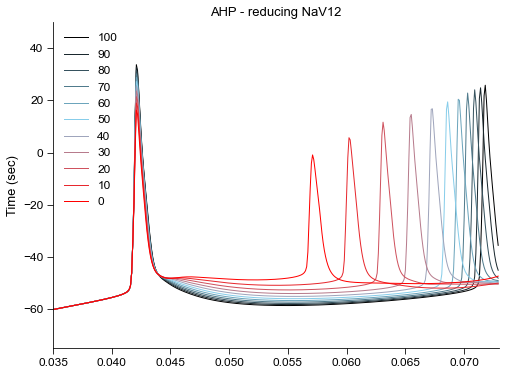

In [117]:
percents = np.arange(1,-0.1,-.1)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (0.5, 'skyblue'),
                                              (1,    'red')], N=256)

fig, ax = ahp_plot_axes()
ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))


for i, p in enumerate(percents):
    init_settings(nav12 = p) ### set conductance here
    Vm, I, t = run_model()
    ax.plot(t[int(35/h.dt):int(73/h.dt)], Vm[int(35/h.dt):int(73/h.dt)], linewidth=1, label = '{}'.format(int(p*100)))

ax.legend(frameon=False)
title='AHP - reducing NaV12'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Increasing axon_Kp in NaV12 Hom

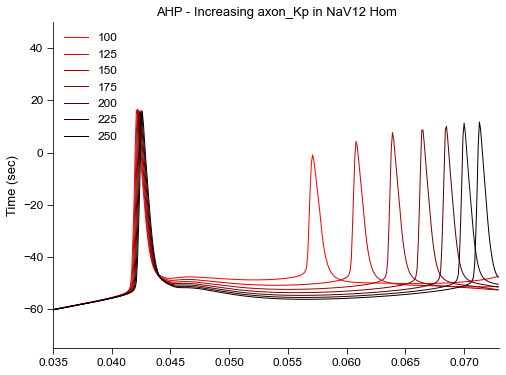

In [118]:
percents = np.arange(1,2.6,.25)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'red'),
                                              (1,    'k')], N=256)

fig, ax = ahp_plot_axes()
ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

for i, p in enumerate(percents):
    init_settings(nav12 = 0, axon_Kp = p) ### set conductance here
    Vm, I, t = run_model()
    ax.plot(t[int(35/h.dt):int(73/h.dt)], Vm[int(35/h.dt):int(73/h.dt)], linewidth=1, label = '{}'.format(int(p*100)))

ax.legend(frameon=False)
title='AHP - Increasing axon_Kp in NaV12 Hom'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## Decreasing axon_Kp in WT

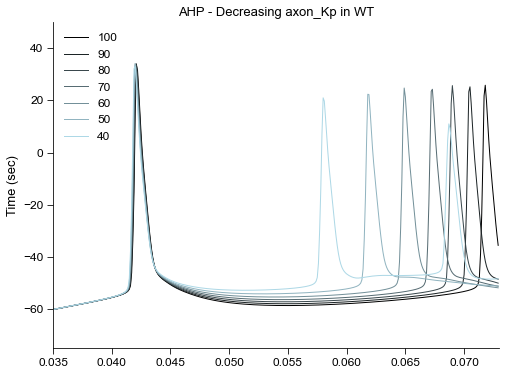

In [119]:
percents = np.arange(1,0.3,-.1)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (1,    'lightblue')], N=256)


fig, ax = ahp_plot_axes()
ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

for i, p in enumerate(percents):
    init_settings(nav12 = 1, axon_Kp = p) ### set conductance here
    Vm, I, t = run_model()
    ax.plot(t[int(35/h.dt):int(73/h.dt)], Vm[int(35/h.dt):int(73/h.dt)], linewidth=1, label = '{}'.format(int(p*100)))

ax.legend(frameon=False)
title='AHP - Decreasing axon_Kp in WT'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

## increasing nav12_soma in NaV12 Hom

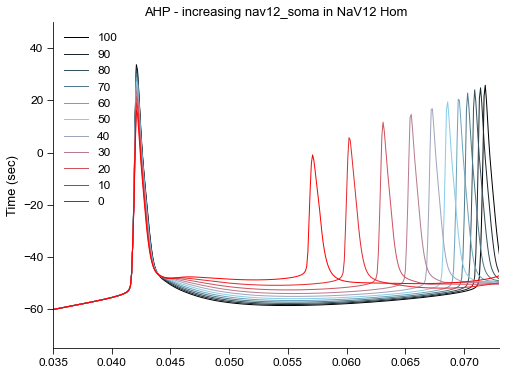

In [120]:
percents = np.arange(1,-0.1,-.1)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (0.5, 'skyblue'),
                                              (1,    'red')], N=256)

fig, ax = ahp_plot_axes()
ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

for i, p in enumerate(percents):
#     init_settings(soma_nav12 = p, ais_nav12 = p, dend_nav12 = p) ### set conductance here
    init_settings(nav12 = p)
    Vm, I, t = run_model()
    ax.plot(t, Vm, linewidth=1, label = '{}'.format(int(p*100)))

ax.legend(frameon=False)
title='AHP - increasing nav12_soma in NaV12 Hom'
plt.title(title)
# plt.savefig(title + '.pdf')
plt.show()

# Currents

## Reducing NaV12

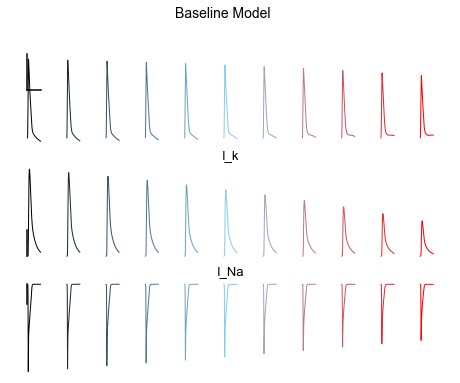

In [121]:
def Na_k_current_plots(label):
    ax2.set_title('I_k')
    ax2.set_xlabel('Time (sec)')
    ax2.set_ylabel('I_k (nA)')
#     ax2.set_ylim(0, 0.8)
    
    ax3.set_title('I_Na')
    ax3.set_xlabel('Time (sec)')
    ax3.set_ylabel('I_Na (nA)')
#     ax3.set_ylim(-2.5, 0)

    Vm, I, t = run_model()
    
    spikes = detect_spike_properties(Vm, t)

    
    spike_start = spikes[0]['start_idx']
    spike_end = spike_start + int(5/dt)
#     spike_end = spikes[0]['end_idx']

    t = t[spike_start:spike_end]
    t = t-t[0]
    Vm = Vm[spike_start:spike_end]
    I_Na = I['Na'][spike_start:spike_end]
    I_K = I['K'][spike_start:spike_end]
    
    ax1.plot(t + i*.015, Vm, linewidth = 1, label = label)    
    ax2.plot(t + i*.015, I_K, linewidth = 1, label = label)
    ax3.plot(t + i*.015, I_Na, linewidth = 1, label = label)

sweep_len = 100
stim_dur = 95
stim_start = 5
amp = 0.35
dt = 0.01

init_stim(sweep_len=sweep_len, 
          stim_start=stim_start,
          stim_dur=stim_dur,
          amp=amp,
          dt=dt)

fig1, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=(8,6), sharex=False, sharey=False)
fig_title = 'Baseline Model'
fig1.suptitle(fig_title) 

percents = np.arange(1,-0.1,-.1)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (0.5, 'skyblue'),
                                              (1,    'red')], N=256)

ax1.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
ax2.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))
ax3.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))

ax1.plot([0, 0], [0, 40], 'k')
ax1.plot([0, 0.005], [0, 0], 'k')
ax2.plot([0, 0], [0, .2], 'k')
ax3.plot([0, 0], [0, -0.5], 'k')

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')


for i, p in enumerate(percents):
    init_settings(nav12 = p)
    Na_k_current_plots(label = '{}'.format(int(p*100)))
    
# ax1.legend(frameon=False, title='NaV1.2 (%)')
# plt.savefig("{}.pdf".format('model_currents_and_spikes'), transparent=True)
plt.show()

100: 1.16
90: 1.16
80: 1.17
70: 1.19
60: 1.2
50: 1.23
40: 1.26
30: 1.31
20: 1.38
10: 1.48
0: 1.62


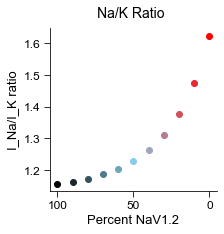

In [122]:
def Na_k_ratio_plot():

    Vm, I, t = run_model()
    t= t-t[0]
    dt = t[1]-t[0]
    dvdt = np.gradient(Vm)/h.dt
    
    spike_start = np.argwhere(dvdt >= 50)[0][0] - int(0.0005 / dt)
    spike_end = spike_start + int(0.01 / dt)

    t = t[spike_start:spike_end]
    t = t-t[0]
    Vm = Vm[spike_start:spike_end]
    I_Na = I['Na'][spike_start:spike_end]
    I_K = I['K'][spike_start:spike_end]
    
    ratio = np.trapz(np.abs(I_Na),t)/np.trapz(I_K,t)
    AP_height = np.max(Vm)
    ax.scatter(int(p * 100), ratio)
    print(f'{int(p*100)}: {np.round(ratio,2)}')


    
sweep_len = 100
stim_dur = 95
stim_start = 5
amp = 0.35
dt = 0.1
init_stim(sweep_len=sweep_len, 
          stim_start=stim_start,
          stim_dur=stim_dur,
          amp=amp,
          dt=dt)

fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3), sharex=False, sharey=False)
fig_title = 'Na/K Ratio'
fig1.suptitle(fig_title) 
ax.set_ylabel('I_Na/I_K ratio')
ax.set_xlabel('Percent NaV1.2')
ax.set_xlim(105, -5)

percents = np.arange(1,-0.1,-.1)
cmap = clr.LinearSegmentedColormap.from_list('scn2a', 
                                             [(0,    'k'),
                                              (0.5, 'skyblue'),
                                              (1,    'red')], N=256)

ax.set_prop_cycle('color',cmap(np.linspace(0,1,len(percents))))


for i, p in enumerate(percents):
    init_settings(nav12 = p)
    Na_k_ratio_plot()
    

# plt.savefig("{}.pdf".format('Na_K_Q_ratio'), transparent=True)
plt.show()